
# CS 369 2020 

Student: Rui Huang

UPI: rhua966

## Assignment 3
Due Date: Tue 27/5/2020 at 22:00

 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

## Question 1: Shotgun Sequencing (10 pts)

In [2]:
class ShotgunSequencing:
    
    def __init__(self, sequence=""):
        self.sequence = sequence
        self.length = len(self.sequence)
    
    @staticmethod
    def readSequence(filename, i=1):
        """
        A static method that return an instance of ShotgunSequencing
        with sequence from filename at index i.
        Return None if filename does not have a sequence at index i.
        Raise error if it cannot find such file.
        """
        sequenceList = []  # Store the starting location(">") of each sequence
        sequence = ""  # Target sequence
        DNA = ["A", "T", "C", "G"]  # Nucleotides
        FILE = "A3_DNAs.fasta"
        
        try:
            
            file = open(filename, "r")

            lines = file.readlines()
            
            file.close()
            
            # Find lines that start with '>'
            for line in lines:
                if line[0] == '>':
                    sequenceList.append(lines.index(line))
            
            # Return None if no such sequence
            if i > len(sequenceList): 
                print("ERROR: Find no sequence")
                return ShotgunSequencing(None)

            index = sequenceList[i - 1]
                    
            while True:
                
                # Find lines that start with nucleotides
                if lines[index][0] not in DNA:
                    index += 1
                
                else:
                    sequence += lines[index][:-1]
                    if index + 1 >= len(lines): 
                        break
                    if lines[index + 1][0] not in DNA:
                        break
                    index += 1

        except (FileNotFoundError, IOError):
        
            print("ERROR: Wrong file or file path.")
            
        return ShotgunSequencing(sequence)
            
    
    def shotgun(self, l_min, l_max):
        """
        It returns the sequence as an array of fragments with random
        length that is uniformly distributed in the range of l_min and l_max
        The last sequence can be shorter than l_min.
        """
        random.seed(0)
        
        fragments = []  # Empty array of fragments
        length = 0  # Total length
        
        while length < self.length:
            
            random_length = random.randint(l_min, l_max)  # Random length 
            
            # The last fragment from the remaining sequence
            if length + random_length > self.length:
                fragments.append(self.sequence[length:])
                break
            
            # Add fragment to the array and increment total length
            fragments.append(self.sequence[length : length + random_length])
            length += random_length
            
        return fragments
        
    
    def cloning(self, l_min, l_max, n):
        """
        Calls the function shotgun(l_min, l_max) n times and 
        returns one sorted (by length) array with all fragments
        """
        clones = []  # Empty array of fragments clone
        count = 0
        
        while count < n:
            clones += self.shotgun(l_min, l_max)  # Add one clone to the array
            count += 1
            
        clones.sort(key=len, reverse=False)  # Sort by length
        return clones


In [3]:
"""Q1 Testing"""

file = "A3_DNAs.fasta"
seq = ShotgunSequencing.readSequence(file, i=1) 

print(f"Sequence: {seq.sequence}\n")
# print(f"Shotguns: {np.array(seq.shotgun(2, 6))}\n")
# print(f"Clonings: {np.array(seq.cloning(2, 6, 2))}")

"""Q1 Testing Finished"""

Sequence: AAGTCCTGGGTCTTCGGTGTCCACTTTTGCAAGCTCATCTTTGCCATCTACAAGATGAGCTTCTTCAGTGGCATGCTCCTACTTCTTTGCATCAGCATTGACCGCTACGTGGCCATCGTCCAGGCTGTCTCAGCTCACCGCCACCGTGCCCGCGTCCTTCTCATCAGCGCGCTGCAGACCACCACCAACTACCTGATCGTCAGCCTCGCAGTGGCCGACCTCCTCGTCGCCACACTG



'Q1 Testing Finished'

## Question 2: Sequence Assembler (35 pts)

In [4]:
import pandas as pd

class SequenceAssembler:
    """
    A class which assembles the fragments into sequence.
    """
    
    def __init__(self, nodes=[], edges=[]):
        
        self.nodes = nodes
        self.edges = edges
        self.graph = {"nodes": self.nodes,
                      "edges": self.edges}
        
    def calculateOverlap(fragA, fragB):
        """
        Return the length of the overlap if fragB follows fragA.
        Example: calculateOverlap(‘AAT’,‘ATG’) should return 2, 
        while calculateOverlap(‘ATG’, ‘AAT’) should return 0.
        """
        
        # Initialization
        i, j = -1, 1
        count = 1
        score = 0
        
        while (i >= - len(fragA)) and (j <= len(fragB)):
            
            # Match suffix of fragA with prefix of fragB
            if fragA[i:] == fragB[:j]:
                score = count
            
            # Shift fragB to the left and fragA to the right
            i -= 1
            j += 1
            count += 1

        return score

    
    @staticmethod
    def createOverlapGraph(fragments):
        """
        Create a unique list of nodes that are not substrings of 
        other fragments and create the corresponding edges between
        each node that have non-zero weights.
        Instanciate and return one SequenceAssembler object with this list of 
        nodes and edges.
        """
        
        temp = []   # Unique nodes list 
        nodes = []  # Unique nodes list with no node being substring of others 
        edges = []  # Using adj list representation
        
        # Remove all duplicates
        for frag in fragments:
            if frag not in nodes:
                temp.append(frag)
        
        # Remove all nodes that are substrings of other nodes
        for i in range(len(temp)):
            
            is_substring = False  # Not substring of other nodes
            for j in range(i+1, len(temp)):
                
                # Check  if it's substring of other nodes 
                if temp[i] in temp[j]:
                    is_substring = True
            if not is_substring:
                nodes.append(temp[i])
        
        
        for i in range(len(nodes)):
            
            weighted_edge = []  # Outgoing edge of nodes[i]
            
            for j in range(len(nodes)):
                
                if i == j: continue  # Nodes are not self connected
                
                overlap_score = SequenceAssembler.calculateOverlap(nodes[i], nodes[j])
                
                # If two nodes are connected, i.e. non zero score
                if overlap_score != 0:
                    
                    # tuple (index of outgoing node, score) as edge
                    weighted_edge.append((j, overlap_score))

            # All the outgoing edge of nodes[i]
            edges.append(weighted_edge)
        
        # Return the Overlap Graph with nodes and edges.
        return SequenceAssembler(nodes, edges)
            
    def getMaxEdge(self):
        """
        Return the edge (i, j) between node[i] and node[j] with 
        highest weight. If it's not unique, filter by total 
        length of two nodes, pick either the only one 
        or a random one.
        """
        
        # Init
        max_weight = 0
        max_edges = [] 
        
        # Traverse through every nodes
        for i in range(len(self.nodes)):
            
            # Traverse every outgoing edge from node at index i 
            for j in range(len(self.edges[i])):
                
                if self.edges[i][j][1] >= max_weight:
                    
                    # Add the current edge to the list if equals
                    if self.edges[i][j][1] == max_weight:
                        max_edges.append((i, self.edges[i][j][0]))

                    
                    # Update both max_weight and max_edge when current
                    # weight is greater than the max_weight.
                    else:
                        max_weight = self.edges[i][j][1]
                        max_edges = [(i, self.edges[i][j][0]),]
        
        # Return the edge if it's unique with max_weight
        if len(max_edges) == 1: return max_weight, max_edges[0]
        
        # If the edge is not the unique one with max_weight
        max_total_length = 0
        max_total_length_edges = []
        
        for edge in max_edges:

            # Calculate total length
            total_length = len(self.nodes[edge[0]]) +\
                           len(self.nodes[edge[1]])
            
            if total_length >= max_total_length:
                
                if total_length == max_total_length:
                    max_total_length_edges.append(edge)
                else:
                    max_total_length = total_length
                    max_total_length_edges = [edge,]
                    
        if len(max_total_length_edges) == 0:
            return 0, []
        
        # If it's the only one with max_total_length
        if len(max_total_length_edges) == 1: 
            return max_weight, max_total_length_edges[0]
        else:
            
            # Pick a random number and return 
            random_index = random.randrange(0,len(max_total_length_edges))
            return max_weight, max_total_length_edges[random_index]
                    
    
    def assembling(self):
        """
        implements the greedy algorithm for Shortest Common Superstring where you 
        merge the nodes until one is left and return the ﬁnal sequence.
        """
        
        temp = self
        
        # Get the current max edge
        weight, edge = temp.getMaxEdge()
        
        # Keep merging until one node left
        while len(temp.nodes) > 1:
            weight, edge = temp.getMaxEdge()
            if len(edge) == 0:
                break
            
            # Two node of the current edge
            node1 = temp.nodes[edge[0]]
            node2 = temp.nodes[edge[1]]
            
            # Merge
            S = node1[:] + node2[weight:]
            new_node_list = []
            
            for i in range(len(temp.nodes)):
                if temp.nodes[i] != node1 and temp.nodes[i] != node2:
                    new_node_list.append(temp.nodes[i])
            new_node_list.append(S)
            temp = SequenceAssembler.createOverlapGraph(new_node_list)
        
        if len(temp.nodes) == 1: return temp.nodes[0]
        
        seq = ""
        for i in range(len(temp.nodes)):
            seq += temp.nodes[i]
        
        return seq


In [5]:
"""Q2 Testing"""
"""Please expect some long running time"""
file = "A3_DNAs.fasta"
Test = ShotgunSequencing.readSequence(file, i=1)
RealmRNA = ShotgunSequencing.readSequence(file, i=2)
seq_list = [Test, RealmRNA]
name = ["Test", "RealmRNA"]
l_min = [5, 10, 20, 50, 100, 200]
l_max = [10, 20, 30, 100, 200, 500]
n = [3, 5, 10, 5, 10, 15]
for i in range(2):
    for j in range(3):
        clone = seq_list[i].cloning(l_min[i*3+j], l_max[i*3+j], n[i*3+j])
        graph = SequenceAssembler.createOverlapGraph(clone)
        sequence = graph.assembling()
        print(f"Sequence: {name[i]}, l_min: {l_min[i*3+j]}, l_max: {l_max[i*3+j]}, n: {n[i*3+j]}")
        print("Resulting sequence:")
        print(sequence)
        print("\n")

Sequence: Test, l_min: 5, l_max: 10, n: 3
Resulting sequence:
AAGTCCTGCCATCGTCCCGCGTCCTACGTGGCCGATGAGCAAGCTCACCTCCTCCTACTTCTTCAGCCTCGCAGACCGCGCTGTCTCATCAGCATTCTTTGCCACCGTGTCGCCACATCTACAACTACCTGGCATGGTCTTCGACCACTTTTCCAG


Sequence: Test, l_min: 10, l_max: 20, n: 5
Resulting sequence:
GCTCATCTTTCCTCGCAGTGGCCATCTACAAGATAGGCTGTCTCAGCTCACGACCTCCTCGTCGTGTCCACTTTTGCAACTACCTGATCGTCAGCATTGACCGCTAAGTCCTGGGTCTTCGTGGCCATCGTCCTTCTCATCAGCGCGCCACCGTGCCCGCTCCTACTTCTTTGCAGACCACCACACTGAGCTTCTTCAGTGGCAT


Sequence: Test, l_min: 20, l_max: 30, n: 10
Resulting sequence:
ACCACCACCAACTACCTGATCGTCATGCTCCTACTTCTTTGCATCAGCCTCGCAGTGGCCGACCTCCTCGTCAAGTCCTGGGTCTTCGGTGTCCACTTGCAAGCTCATCTTTGCCATCTACATTGACCGCTACGTGGCCATCGTCCAGGCGTCCTTCTCATCAGCGCGCTGCAGATGAGCTTCTTCAGTGGCCACACTGTCTCAGCTCACCGCCACCGTGCCC


Sequence: RealmRNA, l_min: 50, l_max: 100, n: 5
Resulting sequence:
AAAGGCAGGTTCAGGTGCTTTGAGGATGTGAGGAGAAAATGTCTGCGGAATGAATGAATACACCGTATAAGAGAGTGGCGGGGCTGGGCTTGGTGGTCTGGCAGAACCTGTTCTCATCATGAGGGTGATAGGTTAGGCCCTCTGGGACAC

If the fragments is too short, it's hard to determine the original position of the fragment since it will have a higher chance to overlap with other fragments that are not connected in the original sequence, thus, longer fragments are prefered.

It will have similiar length to the original sequence.

Cloning will increase the accuracy and similarity between the constructed sequence and the original sequence.

## Question 3: Simulating outbreaks (30 pts)

##### Q3 a)
The epidemic will finish when there is no more infected left, at that time the susceptible will not grow due to the lack of infected, and all the rest will already recover. Then the epidemic will stop.

##### Q3 b,c)

In [6]:
class Simulation:
    """
    A standard SIR model of infectious disease spread in epidemiology
    with a population of N hosts divided into 3 compartments:
    
    • the S compartment of those who are susceptible to the disease

    • the I compartment of those who are infectious with the disease

    • the R compartment of those who are recovered from the disease 
      and now immune (or, more generally, those who are removed from 
      the epidemic either through recovery with immunity or due to death).
    
    Assume S + I + R = N. 
    We consider the stochastic version here. Times between all events 
    are exponentially distributed with the following rates which depend 
    on the current tate of the outbreak, assumed to be (S, I, R):
    
    • the rate of transmissions is BSI/N and the new state is (S − 1, I + 1, R), and
    
    • the rate of recoveries is YI and the new state is (S, I − 1, R + 1).
    
    """
    
    def rand_exp(rate):
        """
        Takes a rata parameter rate and produce an exponentially
        distributed random variable with parameter rate.
        """
#         random.seed(0)
        
        # Draw a uniform distributed rv between 0 and 1
        u = random.uniform(0, 1) 
        
        # Inverse of CDF of exponential distribution
        F_1 = lambda u : (- math.log(1 - u)) / rate
        
        # Transform the uniform number into exponential distribution and return
        return F_1(u)
    
    
    def sim_SIR(N=1000, I_0=10, B=2.2, Y=2):
        """
        Arguments:
            N:    Total population
            I_0:  Initial number of those who are infected
            B:    Rate of transmissions
            Y:    Rate of recoveries
        Outputs a list of the event times and the number susceptible,
        infected and recovered at each time point. All outbreaks start
        at time t = 0
        """
        # Initial state 
        S = susceptible = N - I_0
        I = infected = I_0
        R = recovered = 0
        
        t = 0    # Start time
        T = 100  # Total time
        
        event_count = 0
        event_times = [t,]
        event_states = np.array([S, I, R])
        
        while (t < T):
            
            

            # Finished
            if  I == 0 or R == N: break
              
            # No susceptible left
            elif S == 0 and I != 0:
                t += Simulation.rand_exp(Y*I)
                (S, I, R) = (S, I-1, R+1)
            
            # No infected left
            elif S != 0 and I == 0:
#                 t += Simulation.rand_exp(B*S/N)
                (S, I, R) = (S-1, I+1, R)
            
            elif S != 0 and I != 0:
                
                t += Simulation.rand_exp((B*S*I/N) + (Y*I))
                Pr = (B*S*I/N) / (Y*I)  # Probability of transmission
                u = random.uniform(0,1)
                
                # Event is transmission
                if u <= Pr: 
                    (S, I, R) = (S-1, I+1, R)
                
                # Event is recovery
                else: 
                    (S, I, R) = (S, I-1, R+1)
            
            event_count += 1
            event_times.append(t)
            event_states = np.vstack((event_states, np.array([S, I, R])))
        
                
        threshold = 0.25 * N 
        outbreak = False
        
        # if peak number of infected is larger than the threshold
        if max(event_states[:, 1]) >= threshold:
            outbreak = True
        
        
        return event_times, event_states, outbreak


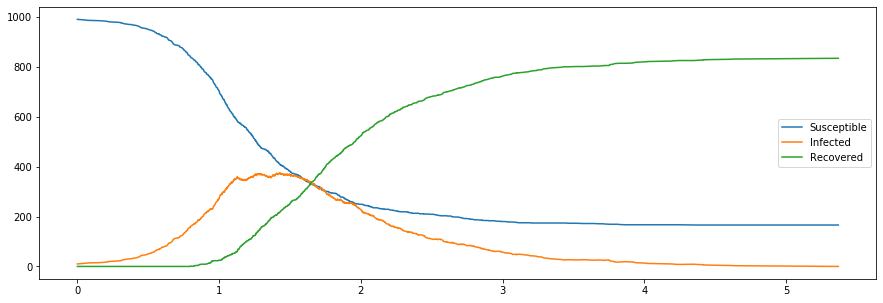

In [7]:
"""Q3 d)"""
times, states, outbreak = Simulation.sim_SIR(N=1000, I_0=10, B=2.2, Y=2)

fig1, ax1 = plt.subplots(figsize=(15,5))
# print(states[:, 2])
ax1.plot(times, states[:, 0], label="Susceptible")
ax1.plot(times, states[:, 1], label="Infected")
ax1.plot(times, states[:, 2], label="Recovered")
ax1.legend()

##### Q3 e)

Frequency of outbreak = 1.0


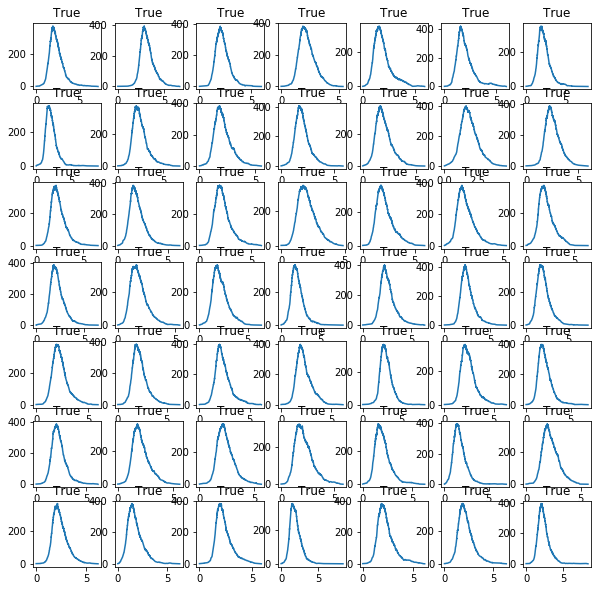

In [8]:
"""Q3 e)"""
n = 7
fig2, ax2 = plt.subplots(n,n, figsize=(10,10))
total_outbreak = 0
for i in range(n):
    for j in range(n):
        times, states, outbreak = Simulation.sim_SIR(N=1000, I_0=1, B=2.2, Y=2)
        if outbreak: total_outbreak += 1
        ax2[i][j].plot(times, states[:, 1], label="Infected")
        ax2[i][j].set_title(f"{outbreak}")
freq = total_outbreak / (n*n)
print(f"Frequency of outbreak = {freq}")

From the above n by n graph of number of infected over time, we can observe that the outbreak will always happen (i.e. number of infected is larger than a threshold), under this initial condition. But if there is no outbreak, then we will know that the curve will normally be flattened and the peak of infected remains low.

##### Q3 f)

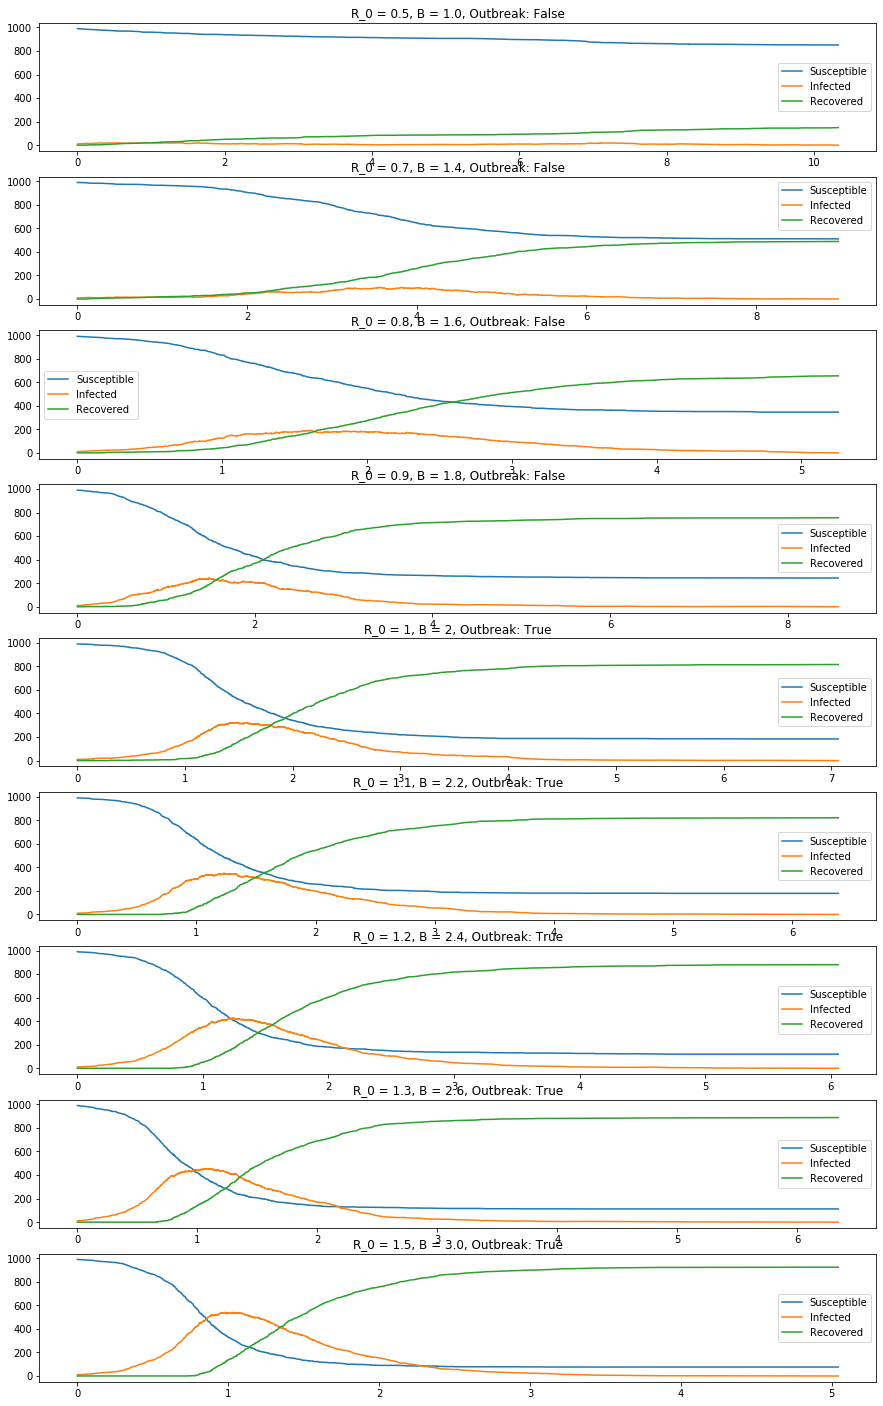

In [9]:
"""Q3 f)"""
times = []
states = []
outbreaks = []
R_list = [0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.5]
for R_0 in R_list:
    time, state, outbreak = Simulation.sim_SIR(N=1000, I_0=10, B=R_0*2, Y=2)
    times.append(time)
    states.append(state)
    outbreaks.append(outbreak)
fig, ax = plt.subplots(9, figsize=(15,25))
for i in range(9):
    ax[i].set_title(f"R_0 = {R_list[i]}, B = {R_list[i]*2}, Outbreak: {outbreaks[i]}")
    ax[i].plot(times[i], states[i][:, 0], label="Susceptible")
    ax[i].plot(times[i], states[i][:, 1], label="Infected")
    ax[i].plot(times[i], states[i][:, 2], label="Recovered")
    ax[i].legend()


I select a list of R_0 = [0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.5]. As we can see from the above graphs, depending on how to define an outbreak, if the reproduction number R_0 is less than 1, the an outbreak is less likely to happen, thus, the peak of infected will be much smaller and delayed to happen, which has a effect of flattening the curve. If R_0 is greater than 1 then quickly a large proportion of susceptible will be infected.

##### Q3 g)
If hosts are infectious for exactly 1 time unit, then this process will no longer be Markov since the next state of the model will depend on how long it have entered the current state, which will affect the transmission rate. I think it will take another variable to track how long it has enter each state and modify the transmission and recover rate to cover the change.